In [1]:
import keras
from keras.layers import Input, Conv1D,Activation,MaxPooling1D,Dense,Flatten,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [31]:
def get_sub_model(myinputs,channel=3,sensors=1):
    x     = Conv1D(filters =8*sensors, kernel_size=5,strides = 1, padding = 'same')(myinputs)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=3,strides = 2,padding='same')(x)
    #  x shape is 64X16 =3072
    x     = Conv1D(filters =12*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    #  x shape is 32X24 = 2048
    x     = Conv1D(filters =16*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 16*32 = 1536
    x     = Conv1D(filters =20*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 8*32 = 1024
    x     = Conv1D(filters =24, kernel_size=3,strides = 2, padding = 'same')(x)
    # x shape is 4*32 = 512

    latent_vector = Flatten()(x)
    # decoder x = 4*128
    x     = Conv1D(filters =24*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 8*128
    x     = Conv1D(filters =20*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 16*96
    x     = Conv1D(filters =16*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 32*64
    x     = Conv1D(filters =12*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 64*48
    x     = Conv1D(filters =8*sensors, kernel_size=3,strides = 1, padding = 'same')(x)
    x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 128*48
    y     = Conv1D(filters =channel, kernel_size=3,strides = 1, padding = 'same')(x)
    #y     = Activation('relu')(x)
    return latent_vector,y

In [38]:
def build_model(name="push_detect",channel=3,sensors=1,inputLength=128):
    # input shape 128X26 =3382
    with tf.name_scope(name):
        myInputs = Input(shape=(inputLength,channel))
                
        LV,Y = get_sub_model(myInputs,channel=channel,sensors=sensors)
        
        autoencoder = Model (inputs=myInputs,
                             outputs =Y)
    
    return autoencoder

In [39]:
inputLength=64
gyroModel=build_model(sensors=3,inputLength=inputLength)
linearAccModel=build_model(sensors=3,inputLength=inputLength)
gravityModel=build_model(sensors=3,inputLength=inputLength)
gameVecModel=build_model(channel=4,sensors=3,inputLength=inputLength)
opt = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
gyroModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=.1, momentum=0.0, decay=0.0, nesterov=False)
linearAccModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=.1, momentum=0.0, decay=0.0, nesterov=False)
gravityModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=.1, momentum=0.0, decay=0.0, nesterov=False)
gameVecModel.compile(optimizer=opt,loss='mae',metrics=['accuracy'])

In [40]:
data= np.load('watch_norm_64.npy')
np.random.shuffle(data)
p=0.85
train_num =int(data.shape[0]*p)
gyro_train=data[:train_num,:,13:16]
linearAcc_train=data[:train_num,:,16:19]
gravity_train=data[:train_num,:,19:22]
gameVec_train=data[:train_num,:,22:26]

gyro_test =data[train_num:,:,13:16]
linearAcc_test =data[train_num:,:,16:19]
gravity_test =data[train_num:,:,19:22]
gameVec_test =data[train_num:,:,22:26]

In [41]:
train_round =50
epochs_per_round=20
for i in range(train_round):
    print('start training round '+str(i))
    print('training gyro model')
    gyroModel.fit(gyro_train,gyro_train,batch_size=256,epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    print('training linearAcc model')
    linearAccModel.fit(linearAcc_train,linearAcc_train,batch_size=256,epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    print('training gravity model')
    gravityModel.fit(gravity_train,gravity_train,batch_size=256,epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    print('training gameVec model')
    gameVecModel.fit(gameVec_train,gameVec_train,batch_size=256,epochs=(i+1)*epochs_per_round,validation_split=0.1,verbose=1,initial_epoch=i*epochs_per_round)
    gyroModel.save('gyroNorModelFFT_64.h5')
    linearAccModel.save('linearAccNorModelFFT_64.h5')
    gravityModel.save('gravityNorModelFFT_64.h5')
    gameVecModel.save('gameVecNorModelFFT_64.h5')

start training round 0
training gyro model
Train on 10976 samples, validate on 1220 samples
Epoch 1/20
10976/10976 [==============================] - 28s 3ms/step - loss: 0.1456 - acc: 0.3480 - val_loss: 0.1318 - val_acc: 0.3459
Epoch 2/20
10976/10976 [==============================] - 6s 519us/step - loss: 0.0659 - acc: 0.3626 - val_loss: 0.0775 - val_acc: 0.3684
Epoch 3/20
10976/10976 [==============================] - 6s 524us/step - loss: 0.0532 - acc: 0.3748 - val_loss: 0.0510 - val_acc: 0.3801
Epoch 4/20
10976/10976 [==============================] - 6s 555us/step - loss: 0.0425 - acc: 0.3834 - val_loss: 0.0467 - val_acc: 0.3851
Epoch 5/20
10976/10976 [==============================] - 6s 521us/step - loss: 0.0369 - acc: 0.3910 - val_loss: 0.0365 - val_acc: 0.3949
Epoch 6/20
10976/10976 [==============================] - 6s 537us/step - loss: 0.0360 - acc: 0.3974 - val_loss: 0.0331 - val_acc: 0.4095
Epoch 7/20
10976/10976 [==============================] - 6s 526us/step - loss: 0

10976/10976 [==============================] - 6s 517us/step - loss: 0.0238 - acc: 0.3347 - val_loss: 0.0236 - val_acc: 0.3681
Epoch 19/20
10976/10976 [==============================] - 6s 513us/step - loss: 0.0240 - acc: 0.3551 - val_loss: 0.0217 - val_acc: 0.3793
Epoch 20/20
10976/10976 [==============================] - 6s 533us/step - loss: 0.0235 - acc: 0.3548 - val_loss: 0.0222 - val_acc: 0.2906
training gameVec model
Train on 10976 samples, validate on 1220 samples
Epoch 1/20
10976/10976 [==============================] - 27s 2ms/step - loss: 0.1246 - acc: 0.2601 - val_loss: 0.0803 - val_acc: 0.3519
Epoch 2/20
10976/10976 [==============================] - 6s 548us/step - loss: 0.0496 - acc: 0.2676 - val_loss: 0.0523 - val_acc: 0.2283
Epoch 3/20
10976/10976 [==============================] - 6s 545us/step - loss: 0.0418 - acc: 0.2663 - val_loss: 0.0463 - val_acc: 0.3548
Epoch 4/20
10976/10976 [==============================] - 6s 572us/step - loss: 0.0393 - acc: 0.2894 - val_los

10976/10976 [==============================] - 7s 594us/step - loss: 0.0297 - acc: 0.4289 - val_loss: 0.0307 - val_acc: 0.3909
Epoch 36/40
10976/10976 [==============================] - 7s 611us/step - loss: 0.0295 - acc: 0.4309 - val_loss: 0.0281 - val_acc: 0.5012
Epoch 37/40
10976/10976 [==============================] - 6s 562us/step - loss: 0.0296 - acc: 0.4357 - val_loss: 0.0311 - val_acc: 0.3414
Epoch 38/40
10976/10976 [==============================] - 6s 576us/step - loss: 0.0294 - acc: 0.4308 - val_loss: 0.0296 - val_acc: 0.5061
Epoch 39/40
10976/10976 [==============================] - 7s 611us/step - loss: 0.0290 - acc: 0.4281 - val_loss: 0.0299 - val_acc: 0.4156
Epoch 40/40
10976/10976 [==============================] - 6s 567us/step - loss: 0.0290 - acc: 0.4406 - val_loss: 0.0294 - val_acc: 0.5067
training gravity model
Train on 10976 samples, validate on 1220 samples
Epoch 21/40
10976/10976 [==============================] - 6s 585us/step - loss: 0.0232 - acc: 0.3449 - va

10976/10976 [==============================] - 6s 561us/step - loss: 0.0234 - acc: 0.4098 - val_loss: 0.0236 - val_acc: 0.4588
Epoch 53/60
10976/10976 [==============================] - 6s 566us/step - loss: 0.0240 - acc: 0.4242 - val_loss: 0.0204 - val_acc: 0.4618
Epoch 54/60
10976/10976 [==============================] - 6s 550us/step - loss: 0.0240 - acc: 0.4317 - val_loss: 0.0267 - val_acc: 0.3687
Epoch 55/60
10976/10976 [==============================] - 6s 572us/step - loss: 0.0236 - acc: 0.4149 - val_loss: 0.0211 - val_acc: 0.4683
Epoch 56/60
10976/10976 [==============================] - 6s 556us/step - loss: 0.0236 - acc: 0.4168 - val_loss: 0.0244 - val_acc: 0.3687
Epoch 57/60
10976/10976 [==============================] - 6s 514us/step - loss: 0.0235 - acc: 0.4172 - val_loss: 0.0195 - val_acc: 0.4701
Epoch 58/60
10976/10976 [==============================] - 6s 549us/step - loss: 0.0235 - acc: 0.4113 - val_loss: 0.0241 - val_acc: 0.3772
Epoch 59/60
10976/10976 [==============

10976/10976 [==============================] - 6s 561us/step - loss: 0.0189 - acc: 0.2437 - val_loss: 0.0197 - val_acc: 0.3744
Epoch 50/60
10976/10976 [==============================] - 6s 544us/step - loss: 0.0189 - acc: 0.2474 - val_loss: 0.0187 - val_acc: 0.1289
Epoch 51/60
10976/10976 [==============================] - 6s 559us/step - loss: 0.0186 - acc: 0.2671 - val_loss: 0.0172 - val_acc: 0.3307
Epoch 52/60
10976/10976 [==============================] - 6s 562us/step - loss: 0.0183 - acc: 0.2994 - val_loss: 0.0169 - val_acc: 0.2826
Epoch 53/60
10976/10976 [==============================] - 6s 517us/step - loss: 0.0182 - acc: 0.2997 - val_loss: 0.0187 - val_acc: 0.3227
Epoch 54/60
10976/10976 [==============================] - 6s 563us/step - loss: 0.0184 - acc: 0.3102 - val_loss: 0.0186 - val_acc: 0.2334
Epoch 55/60
10976/10976 [==============================] - 6s 570us/step - loss: 0.0182 - acc: 0.2875 - val_loss: 0.0194 - val_acc: 0.3654
Epoch 56/60
10976/10976 [==============

10976/10976 [==============================] - 6s 566us/step - loss: 0.0205 - acc: 0.3219 - val_loss: 0.0214 - val_acc: 0.4118
Epoch 67/80
10976/10976 [==============================] - 6s 515us/step - loss: 0.0203 - acc: 0.3195 - val_loss: 0.0179 - val_acc: 0.2165
Epoch 68/80
10976/10976 [==============================] - 6s 550us/step - loss: 0.0202 - acc: 0.3244 - val_loss: 0.0212 - val_acc: 0.4159
Epoch 69/80
10976/10976 [==============================] - 7s 604us/step - loss: 0.0202 - acc: 0.3194 - val_loss: 0.0187 - val_acc: 0.2095
Epoch 70/80
10976/10976 [==============================] - 6s 582us/step - loss: 0.0199 - acc: 0.3917 - val_loss: 0.0182 - val_acc: 0.4154
Epoch 71/80
10976/10976 [==============================] - 6s 575us/step - loss: 0.0202 - acc: 0.4358 - val_loss: 0.0248 - val_acc: 0.4786
Epoch 72/80
10976/10976 [==============================] - 6s 569us/step - loss: 0.0202 - acc: 0.4234 - val_loss: 0.0142 - val_acc: 0.4895
Epoch 73/80
10976/10976 [==============

10976/10976 [==============================] - 6s 570us/step - loss: 0.0263 - acc: 0.4703 - val_loss: 0.0259 - val_acc: 0.4899
Epoch 84/100
10976/10976 [==============================] - 6s 544us/step - loss: 0.0259 - acc: 0.4575 - val_loss: 0.0262 - val_acc: 0.3850
Epoch 85/100
10976/10976 [==============================] - 6s 577us/step - loss: 0.0258 - acc: 0.4417 - val_loss: 0.0266 - val_acc: 0.5152
Epoch 86/100
10976/10976 [==============================] - 6s 550us/step - loss: 0.0260 - acc: 0.4476 - val_loss: 0.0238 - val_acc: 0.4624
Epoch 87/100
10976/10976 [==============================] - 6s 556us/step - loss: 0.0260 - acc: 0.4501 - val_loss: 0.0243 - val_acc: 0.5068
Epoch 88/100
10976/10976 [==============================] - 6s 574us/step - loss: 0.0260 - acc: 0.4695 - val_loss: 0.0272 - val_acc: 0.5163
Epoch 89/100
10976/10976 [==============================] - 6s 540us/step - loss: 0.0263 - acc: 0.4639 - val_loss: 0.0264 - val_acc: 0.4984
Epoch 90/100
10976/10976 [=======

10976/10976 [==============================] - 6s 557us/step - loss: 0.0171 - acc: 0.3072 - val_loss: 0.0168 - val_acc: 0.2662
start training round 5
training gyro model
Train on 10976 samples, validate on 1220 samples
Epoch 101/120
10976/10976 [==============================] - 6s 548us/step - loss: 0.0216 - acc: 0.4184 - val_loss: 0.0204 - val_acc: 0.3879
Epoch 102/120
10976/10976 [==============================] - 6s 522us/step - loss: 0.0219 - acc: 0.4141 - val_loss: 0.0226 - val_acc: 0.4514
Epoch 103/120
10976/10976 [==============================] - 6s 535us/step - loss: 0.0225 - acc: 0.4171 - val_loss: 0.0218 - val_acc: 0.4287
Epoch 104/120
10976/10976 [==============================] - 6s 548us/step - loss: 0.0222 - acc: 0.4174 - val_loss: 0.0208 - val_acc: 0.3882
Epoch 105/120
10976/10976 [==============================] - 6s 529us/step - loss: 0.0219 - acc: 0.4169 - val_loss: 0.0234 - val_acc: 0.4396
Epoch 106/120
10976/10976 [==============================] - 6s 548us/step -

10976/10976 [==============================] - 5s 489us/step - loss: 0.0194 - acc: 0.3942 - val_loss: 0.0259 - val_acc: 0.4043
Epoch 117/120
10976/10976 [==============================] - 6s 519us/step - loss: 0.0196 - acc: 0.4165 - val_loss: 0.0146 - val_acc: 0.4896
Epoch 118/120
10976/10976 [==============================] - 6s 501us/step - loss: 0.0193 - acc: 0.4310 - val_loss: 0.0252 - val_acc: 0.4117
Epoch 119/120
10976/10976 [==============================] - 6s 526us/step - loss: 0.0196 - acc: 0.4267 - val_loss: 0.0135 - val_acc: 0.4921
Epoch 120/120
10976/10976 [==============================] - 6s 540us/step - loss: 0.0192 - acc: 0.4394 - val_loss: 0.0259 - val_acc: 0.4901
training gameVec model
Train on 10976 samples, validate on 1220 samples
Epoch 101/120
10976/10976 [==============================] - 5s 498us/step - loss: 0.0168 - acc: 0.3173 - val_loss: 0.0177 - val_acc: 0.3900
Epoch 102/120
10976/10976 [==============================] - 6s 504us/step - loss: 0.0169 - acc:

10976/10976 [==============================] - 6s 514us/step - loss: 0.0249 - acc: 0.4758 - val_loss: 0.0259 - val_acc: 0.4675
Epoch 133/140
10976/10976 [==============================] - 6s 518us/step - loss: 0.0253 - acc: 0.4748 - val_loss: 0.0257 - val_acc: 0.5230
Epoch 134/140
10976/10976 [==============================] - 5s 497us/step - loss: 0.0250 - acc: 0.4811 - val_loss: 0.0267 - val_acc: 0.4683
Epoch 135/140
10976/10976 [==============================] - 6s 506us/step - loss: 0.0252 - acc: 0.4765 - val_loss: 0.0245 - val_acc: 0.5152
Epoch 136/140
10976/10976 [==============================] - 5s 490us/step - loss: 0.0244 - acc: 0.4731 - val_loss: 0.0255 - val_acc: 0.4845
Epoch 137/140
10976/10976 [==============================] - 6s 523us/step - loss: 0.0244 - acc: 0.4514 - val_loss: 0.0250 - val_acc: 0.4120
Epoch 138/140
10976/10976 [==============================] - 6s 531us/step - loss: 0.0250 - acc: 0.4492 - val_loss: 0.0255 - val_acc: 0.4415
Epoch 139/140
10976/10976 [

10976/10976 [==============================] - 6s 550us/step - loss: 0.0209 - acc: 0.4269 - val_loss: 0.0209 - val_acc: 0.3935
Epoch 149/160
10976/10976 [==============================] - 6s 543us/step - loss: 0.0212 - acc: 0.4223 - val_loss: 0.0223 - val_acc: 0.4438
Epoch 150/160
10976/10976 [==============================] - 6s 524us/step - loss: 0.0212 - acc: 0.4234 - val_loss: 0.0192 - val_acc: 0.3939
Epoch 151/160
10976/10976 [==============================] - 6s 506us/step - loss: 0.0211 - acc: 0.4158 - val_loss: 0.0191 - val_acc: 0.3798
Epoch 152/160
10976/10976 [==============================] - 5s 488us/step - loss: 0.0210 - acc: 0.4161 - val_loss: 0.0191 - val_acc: 0.3993
Epoch 153/160
10976/10976 [==============================] - 6s 530us/step - loss: 0.0209 - acc: 0.4199 - val_loss: 0.0233 - val_acc: 0.4617
Epoch 154/160
10976/10976 [==============================] - 6s 551us/step - loss: 0.0209 - acc: 0.4247 - val_loss: 0.0177 - val_acc: 0.3999
Epoch 155/160
10976/10976 [

10976/10976 [==============================] - 6s 520us/step - loss: 0.0163 - acc: 0.2914 - val_loss: 0.0133 - val_acc: 0.3407
Epoch 145/160
10976/10976 [==============================] - 6s 534us/step - loss: 0.0162 - acc: 0.2915 - val_loss: 0.0172 - val_acc: 0.2677
Epoch 146/160
10976/10976 [==============================] - 6s 528us/step - loss: 0.0164 - acc: 0.2895 - val_loss: 0.0155 - val_acc: 0.2537
Epoch 147/160
10976/10976 [==============================] - 6s 521us/step - loss: 0.0162 - acc: 0.2950 - val_loss: 0.0158 - val_acc: 0.3964
Epoch 148/160
10976/10976 [==============================] - 6s 509us/step - loss: 0.0165 - acc: 0.3097 - val_loss: 0.0121 - val_acc: 0.3639
Epoch 149/160
10976/10976 [==============================] - 6s 520us/step - loss: 0.0161 - acc: 0.3088 - val_loss: 0.0145 - val_acc: 0.2742
Epoch 150/160
10976/10976 [==============================] - 6s 513us/step - loss: 0.0160 - acc: 0.3007 - val_loss: 0.0156 - val_acc: 0.2728
Epoch 151/160
10976/10976 [

10976/10976 [==============================] - 6s 531us/step - loss: 0.0192 - acc: 0.4182 - val_loss: 0.0140 - val_acc: 0.4954
Epoch 162/180
10976/10976 [==============================] - 6s 507us/step - loss: 0.0189 - acc: 0.4164 - val_loss: 0.0231 - val_acc: 0.4058
Epoch 163/180
10976/10976 [==============================] - 6s 536us/step - loss: 0.0188 - acc: 0.4240 - val_loss: 0.0139 - val_acc: 0.4979
Epoch 164/180
10976/10976 [==============================] - 6s 514us/step - loss: 0.0186 - acc: 0.4173 - val_loss: 0.0254 - val_acc: 0.4146
Epoch 165/180
10976/10976 [==============================] - 6s 516us/step - loss: 0.0189 - acc: 0.4437 - val_loss: 0.0138 - val_acc: 0.4934
Epoch 166/180
10976/10976 [==============================] - 6s 503us/step - loss: 0.0189 - acc: 0.4091 - val_loss: 0.0246 - val_acc: 0.4168
Epoch 167/180
10976/10976 [==============================] - 6s 527us/step - loss: 0.0192 - acc: 0.4266 - val_loss: 0.0126 - val_acc: 0.4919
Epoch 168/180
10976/10976 [

10976/10976 [==============================] - 6s 510us/step - loss: 0.0205 - acc: 0.4606 - val_loss: 0.0194 - val_acc: 0.4795
Epoch 199/200
10976/10976 [==============================] - 6s 534us/step - loss: 0.0205 - acc: 0.4623 - val_loss: 0.0249 - val_acc: 0.4689
Epoch 200/200
10976/10976 [==============================] - 6s 512us/step - loss: 0.0202 - acc: 0.4624 - val_loss: 0.0178 - val_acc: 0.4654
training linearAcc model
Train on 10976 samples, validate on 1220 samples
Epoch 181/200
10976/10976 [==============================] - 6s 508us/step - loss: 0.0241 - acc: 0.4835 - val_loss: 0.0240 - val_acc: 0.4802
Epoch 182/200
10976/10976 [==============================] - 6s 516us/step - loss: 0.0241 - acc: 0.4826 - val_loss: 0.0230 - val_acc: 0.5062
Epoch 183/200
10976/10976 [==============================] - 6s 503us/step - loss: 0.0240 - acc: 0.4845 - val_loss: 0.0227 - val_acc: 0.4185
Epoch 184/200
10976/10976 [==============================] - 6s 509us/step - loss: 0.0245 - ac

10976/10976 [==============================] - 6s 526us/step - loss: 0.0157 - acc: 0.3328 - val_loss: 0.0152 - val_acc: 0.3397
Epoch 195/200
10976/10976 [==============================] - 6s 539us/step - loss: 0.0157 - acc: 0.3413 - val_loss: 0.0157 - val_acc: 0.3371
Epoch 196/200
10976/10976 [==============================] - 6s 522us/step - loss: 0.0157 - acc: 0.3389 - val_loss: 0.0153 - val_acc: 0.3366
Epoch 197/200
10976/10976 [==============================] - 6s 513us/step - loss: 0.0157 - acc: 0.3391 - val_loss: 0.0154 - val_acc: 0.3852
Epoch 198/200
10976/10976 [==============================] - 6s 523us/step - loss: 0.0158 - acc: 0.3471 - val_loss: 0.0155 - val_acc: 0.3421
Epoch 199/200
10976/10976 [==============================] - 6s 516us/step - loss: 0.0157 - acc: 0.3452 - val_loss: 0.0146 - val_acc: 0.3351
Epoch 200/200
10976/10976 [==============================] - 6s 512us/step - loss: 0.0156 - acc: 0.3397 - val_loss: 0.0149 - val_acc: 0.3439
start training round 10
tra

10976/10976 [==============================] - 6s 528us/step - loss: 0.0186 - acc: 0.3387 - val_loss: 0.0184 - val_acc: 0.2166
Epoch 211/220
10976/10976 [==============================] - 6s 513us/step - loss: 0.0186 - acc: 0.3379 - val_loss: 0.0207 - val_acc: 0.4966
Epoch 212/220
10976/10976 [==============================] - 6s 535us/step - loss: 0.0184 - acc: 0.3438 - val_loss: 0.0160 - val_acc: 0.2208
Epoch 213/220
10976/10976 [==============================] - 6s 531us/step - loss: 0.0185 - acc: 0.3375 - val_loss: 0.0215 - val_acc: 0.4956
Epoch 214/220
10976/10976 [==============================] - 5s 491us/step - loss: 0.0185 - acc: 0.3332 - val_loss: 0.0201 - val_acc: 0.2129
Epoch 215/220
10976/10976 [==============================] - 6s 502us/step - loss: 0.0186 - acc: 0.3326 - val_loss: 0.0210 - val_acc: 0.4321
Epoch 216/220
10976/10976 [==============================] - 6s 515us/step - loss: 0.0185 - acc: 0.3408 - val_loss: 0.0172 - val_acc: 0.2191
Epoch 217/220
10976/10976 [

10976/10976 [==============================] - 6s 527us/step - loss: 0.0236 - acc: 0.4280 - val_loss: 0.0240 - val_acc: 0.4961
Epoch 227/240
10976/10976 [==============================] - 5s 489us/step - loss: 0.0234 - acc: 0.4349 - val_loss: 0.0233 - val_acc: 0.3766
Epoch 228/240
10976/10976 [==============================] - 5s 489us/step - loss: 0.0238 - acc: 0.4782 - val_loss: 0.0237 - val_acc: 0.5241
Epoch 229/240
10976/10976 [==============================] - 6s 506us/step - loss: 0.0236 - acc: 0.4897 - val_loss: 0.0238 - val_acc: 0.4390
Epoch 230/240
10976/10976 [==============================] - 6s 524us/step - loss: 0.0237 - acc: 0.4887 - val_loss: 0.0233 - val_acc: 0.5395
Epoch 231/240
10976/10976 [==============================] - 6s 513us/step - loss: 0.0236 - acc: 0.4908 - val_loss: 0.0241 - val_acc: 0.4880
Epoch 232/240
10976/10976 [==============================] - 6s 511us/step - loss: 0.0238 - acc: 0.4905 - val_loss: 0.0239 - val_acc: 0.5089
Epoch 233/240
10976/10976 [

10976/10976 [==============================] - 6s 537us/step - loss: 0.0199 - acc: 0.4617 - val_loss: 0.0177 - val_acc: 0.4670
Epoch 243/260
10976/10976 [==============================] - 6s 522us/step - loss: 0.0202 - acc: 0.4629 - val_loss: 0.0233 - val_acc: 0.4644
Epoch 244/260
10976/10976 [==============================] - 5s 497us/step - loss: 0.0204 - acc: 0.4671 - val_loss: 0.0151 - val_acc: 0.4848
Epoch 245/260
10976/10976 [==============================] - 6s 520us/step - loss: 0.0196 - acc: 0.4588 - val_loss: 0.0239 - val_acc: 0.4741
Epoch 246/260
10976/10976 [==============================] - 5s 495us/step - loss: 0.0204 - acc: 0.4672 - val_loss: 0.0169 - val_acc: 0.4790
Epoch 247/260
10976/10976 [==============================] - 5s 476us/step - loss: 0.0199 - acc: 0.4650 - val_loss: 0.0225 - val_acc: 0.4652
Epoch 248/260
10976/10976 [==============================] - 6s 506us/step - loss: 0.0208 - acc: 0.4619 - val_loss: 0.0235 - val_acc: 0.4566
Epoch 249/260
10976/10976 [

10976/10976 [==============================] - 6s 518us/step - loss: 0.0183 - acc: 0.3319 - val_loss: 0.0208 - val_acc: 0.5040
Epoch 260/260
10976/10976 [==============================] - 6s 509us/step - loss: 0.0182 - acc: 0.3389 - val_loss: 0.0168 - val_acc: 0.2183
training gameVec model
Train on 10976 samples, validate on 1220 samples
Epoch 241/260
10976/10976 [==============================] - 6s 535us/step - loss: 0.0155 - acc: 0.4020 - val_loss: 0.0182 - val_acc: 0.4234
Epoch 242/260
10976/10976 [==============================] - 6s 542us/step - loss: 0.0155 - acc: 0.3957 - val_loss: 0.0127 - val_acc: 0.4257
Epoch 243/260
10976/10976 [==============================] - 6s 508us/step - loss: 0.0153 - acc: 0.3980 - val_loss: 0.0182 - val_acc: 0.4081
Epoch 244/260
10976/10976 [==============================] - 6s 529us/step - loss: 0.0154 - acc: 0.3983 - val_loss: 0.0128 - val_acc: 0.4482
Epoch 245/260
10976/10976 [==============================] - 6s 530us/step - loss: 0.0153 - acc:

10976/10976 [==============================] - 5s 492us/step - loss: 0.0233 - acc: 0.4362 - val_loss: 0.0235 - val_acc: 0.3751
Epoch 276/280
10976/10976 [==============================] - 6s 524us/step - loss: 0.0231 - acc: 0.4429 - val_loss: 0.0236 - val_acc: 0.4247
Epoch 277/280
10976/10976 [==============================] - 6s 521us/step - loss: 0.0232 - acc: 0.4425 - val_loss: 0.0232 - val_acc: 0.4008
Epoch 278/280
10976/10976 [==============================] - 6s 520us/step - loss: 0.0230 - acc: 0.4389 - val_loss: 0.0223 - val_acc: 0.4591
Epoch 279/280
10976/10976 [==============================] - 6s 518us/step - loss: 0.0234 - acc: 0.5032 - val_loss: 0.0217 - val_acc: 0.5352
Epoch 280/280
10976/10976 [==============================] - 6s 525us/step - loss: 0.0234 - acc: 0.5034 - val_loss: 0.0239 - val_acc: 0.4686
training gravity model
Train on 10976 samples, validate on 1220 samples
Epoch 261/280
10976/10976 [==============================] - 6s 504us/step - loss: 0.0180 - acc:

10976/10976 [==============================] - 6s 509us/step - loss: 0.0197 - acc: 0.4301 - val_loss: 0.0189 - val_acc: 0.3810
Epoch 292/300
10976/10976 [==============================] - 6s 520us/step - loss: 0.0201 - acc: 0.4240 - val_loss: 0.0207 - val_acc: 0.4794
Epoch 293/300
10976/10976 [==============================] - 6s 523us/step - loss: 0.0195 - acc: 0.4245 - val_loss: 0.0194 - val_acc: 0.3790
Epoch 294/300
10976/10976 [==============================] - 6s 528us/step - loss: 0.0201 - acc: 0.4238 - val_loss: 0.0212 - val_acc: 0.4801
Epoch 295/300
10976/10976 [==============================] - 6s 519us/step - loss: 0.0197 - acc: 0.4267 - val_loss: 0.0204 - val_acc: 0.3739
Epoch 296/300
10976/10976 [==============================] - 6s 515us/step - loss: 0.0195 - acc: 0.4247 - val_loss: 0.0210 - val_acc: 0.4807
Epoch 297/300
10976/10976 [==============================] - 6s 503us/step - loss: 0.0195 - acc: 0.4305 - val_loss: 0.0187 - val_acc: 0.3775
Epoch 298/300
10976/10976 [

10976/10976 [==============================] - 6s 517us/step - loss: 0.0151 - acc: 0.4190 - val_loss: 0.0157 - val_acc: 0.4196
Epoch 288/300
10976/10976 [==============================] - 6s 523us/step - loss: 0.0153 - acc: 0.4192 - val_loss: 0.0140 - val_acc: 0.3848
Epoch 289/300
10976/10976 [==============================] - 6s 519us/step - loss: 0.0154 - acc: 0.4067 - val_loss: 0.0189 - val_acc: 0.4288
Epoch 290/300
10976/10976 [==============================] - 6s 541us/step - loss: 0.0153 - acc: 0.4078 - val_loss: 0.0105 - val_acc: 0.4652
Epoch 291/300
10976/10976 [==============================] - 6s 509us/step - loss: 0.0151 - acc: 0.4128 - val_loss: 0.0176 - val_acc: 0.4131
Epoch 292/300
10976/10976 [==============================] - 6s 528us/step - loss: 0.0150 - acc: 0.4153 - val_loss: 0.0108 - val_acc: 0.3936
Epoch 293/300
10976/10976 [==============================] - 6s 526us/step - loss: 0.0150 - acc: 0.4074 - val_loss: 0.0184 - val_acc: 0.4177
Epoch 294/300
10976/10976 [

10976/10976 [==============================] - 6s 513us/step - loss: 0.0181 - acc: 0.4692 - val_loss: 0.0148 - val_acc: 0.2836
Epoch 304/320
10976/10976 [==============================] - 6s 531us/step - loss: 0.0178 - acc: 0.4279 - val_loss: 0.0242 - val_acc: 0.2942
Epoch 305/320
10976/10976 [==============================] - 6s 514us/step - loss: 0.0180 - acc: 0.4385 - val_loss: 0.0126 - val_acc: 0.5081
Epoch 306/320
10976/10976 [==============================] - 6s 536us/step - loss: 0.0181 - acc: 0.4578 - val_loss: 0.0222 - val_acc: 0.4255
Epoch 307/320
10976/10976 [==============================] - 6s 543us/step - loss: 0.0179 - acc: 0.4603 - val_loss: 0.0121 - val_acc: 0.5114
Epoch 308/320
10976/10976 [==============================] - 6s 527us/step - loss: 0.0177 - acc: 0.4647 - val_loss: 0.0251 - val_acc: 0.4421
Epoch 309/320
10976/10976 [==============================] - 6s 522us/step - loss: 0.0178 - acc: 0.4359 - val_loss: 0.0136 - val_acc: 0.2914
Epoch 310/320
10976/10976 [

10976/10976 [==============================] - 5s 500us/step - loss: 0.0195 - acc: 0.4722 - val_loss: 0.0156 - val_acc: 0.4879
training linearAcc model
Train on 10976 samples, validate on 1220 samples
Epoch 321/340
10976/10976 [==============================] - 6s 510us/step - loss: 0.0227 - acc: 0.4428 - val_loss: 0.0232 - val_acc: 0.4387
Epoch 322/340
10976/10976 [==============================] - 6s 529us/step - loss: 0.0229 - acc: 0.4821 - val_loss: 0.0231 - val_acc: 0.5434
Epoch 323/340
10976/10976 [==============================] - 6s 525us/step - loss: 0.0226 - acc: 0.4683 - val_loss: 0.0231 - val_acc: 0.3841
Epoch 324/340
10976/10976 [==============================] - 6s 543us/step - loss: 0.0227 - acc: 0.4488 - val_loss: 0.0226 - val_acc: 0.5108
Epoch 325/340
10976/10976 [==============================] - 6s 511us/step - loss: 0.0227 - acc: 0.4520 - val_loss: 0.0232 - val_acc: 0.3759
Epoch 326/340
10976/10976 [==============================] - 6s 542us/step - loss: 0.0228 - ac

10976/10976 [==============================] - 6s 522us/step - loss: 0.0149 - acc: 0.3625 - val_loss: 0.0125 - val_acc: 0.3195
Epoch 337/340
10976/10976 [==============================] - 6s 524us/step - loss: 0.0149 - acc: 0.3631 - val_loss: 0.0160 - val_acc: 0.4263
Epoch 338/340
10976/10976 [==============================] - 6s 530us/step - loss: 0.0150 - acc: 0.3613 - val_loss: 0.0126 - val_acc: 0.3109
Epoch 339/340
10976/10976 [==============================] - 6s 516us/step - loss: 0.0150 - acc: 0.3627 - val_loss: 0.0164 - val_acc: 0.4311
Epoch 340/340
10976/10976 [==============================] - 6s 529us/step - loss: 0.0151 - acc: 0.3608 - val_loss: 0.0133 - val_acc: 0.3063
start training round 17
training gyro model
Train on 10976 samples, validate on 1220 samples
Epoch 341/360
10976/10976 [==============================] - 6s 523us/step - loss: 0.0197 - acc: 0.4705 - val_loss: 0.0233 - val_acc: 0.4686
Epoch 342/360
10976/10976 [==============================] - 6s 535us/step 

10976/10976 [==============================] - 5s 441us/step - loss: 0.0175 - acc: 0.4521 - val_loss: 0.0242 - val_acc: 0.3045
Epoch 353/360
10976/10976 [==============================] - 5s 428us/step - loss: 0.0175 - acc: 0.4403 - val_loss: 0.0134 - val_acc: 0.5104
Epoch 354/360
10976/10976 [==============================] - 5s 433us/step - loss: 0.0177 - acc: 0.4200 - val_loss: 0.0245 - val_acc: 0.4436
Epoch 355/360
10976/10976 [==============================] - 5s 437us/step - loss: 0.0179 - acc: 0.4345 - val_loss: 0.0113 - val_acc: 0.4444
Epoch 356/360
10976/10976 [==============================] - 5s 433us/step - loss: 0.0176 - acc: 0.4330 - val_loss: 0.0245 - val_acc: 0.4438
Epoch 357/360
10976/10976 [==============================] - 5s 435us/step - loss: 0.0179 - acc: 0.4343 - val_loss: 0.0128 - val_acc: 0.4268
Epoch 358/360
10976/10976 [==============================] - 5s 429us/step - loss: 0.0175 - acc: 0.4320 - val_loss: 0.0241 - val_acc: 0.4481
Epoch 359/360
10976/10976 [

10976/10976 [==============================] - 6s 529us/step - loss: 0.0229 - acc: 0.5138 - val_loss: 0.0220 - val_acc: 0.5339
Epoch 369/380
10976/10976 [==============================] - 6s 542us/step - loss: 0.0229 - acc: 0.5151 - val_loss: 0.0241 - val_acc: 0.5127
Epoch 370/380
10976/10976 [==============================] - 6s 565us/step - loss: 0.0223 - acc: 0.5097 - val_loss: 0.0240 - val_acc: 0.5523
Epoch 371/380
10976/10976 [==============================] - 6s 552us/step - loss: 0.0223 - acc: 0.5147 - val_loss: 0.0237 - val_acc: 0.4925
Epoch 372/380
10976/10976 [==============================] - 6s 515us/step - loss: 0.0229 - acc: 0.5197 - val_loss: 0.0245 - val_acc: 0.5253
Epoch 373/380
10976/10976 [==============================] - 6s 527us/step - loss: 0.0227 - acc: 0.5164 - val_loss: 0.0221 - val_acc: 0.5028
Epoch 374/380
10976/10976 [==============================] - 6s 540us/step - loss: 0.0225 - acc: 0.5090 - val_loss: 0.0221 - val_acc: 0.5530
Epoch 375/380
10976/10976 [

10976/10976 [==============================] - 6s 546us/step - loss: 0.0195 - acc: 0.4748 - val_loss: 0.0191 - val_acc: 0.4848
Epoch 385/400
10976/10976 [==============================] - 6s 537us/step - loss: 0.0195 - acc: 0.4759 - val_loss: 0.0240 - val_acc: 0.4780
Epoch 386/400
10976/10976 [==============================] - 5s 495us/step - loss: 0.0197 - acc: 0.4746 - val_loss: 0.0171 - val_acc: 0.4814
Epoch 387/400
10976/10976 [==============================] - 6s 522us/step - loss: 0.0192 - acc: 0.4728 - val_loss: 0.0220 - val_acc: 0.4665
Epoch 388/400
10976/10976 [==============================] - 6s 528us/step - loss: 0.0191 - acc: 0.4757 - val_loss: 0.0157 - val_acc: 0.4766
Epoch 389/400
10976/10976 [==============================] - 6s 530us/step - loss: 0.0191 - acc: 0.4738 - val_loss: 0.0219 - val_acc: 0.4855
Epoch 390/400
10976/10976 [==============================] - 6s 552us/step - loss: 0.0193 - acc: 0.4683 - val_loss: 0.0160 - val_acc: 0.4904
Epoch 391/400
10976/10976 [

10976/10976 [==============================] - 6s 545us/step - loss: 0.0147 - acc: 0.3680 - val_loss: 0.0158 - val_acc: 0.4392
Epoch 382/400
10976/10976 [==============================] - 6s 546us/step - loss: 0.0148 - acc: 0.3701 - val_loss: 0.0133 - val_acc: 0.3119
Epoch 383/400
10976/10976 [==============================] - 6s 530us/step - loss: 0.0147 - acc: 0.3651 - val_loss: 0.0156 - val_acc: 0.4300
Epoch 384/400
10976/10976 [==============================] - 6s 550us/step - loss: 0.0147 - acc: 0.3709 - val_loss: 0.0131 - val_acc: 0.3116
Epoch 385/400
10976/10976 [==============================] - 6s 541us/step - loss: 0.0146 - acc: 0.3670 - val_loss: 0.0162 - val_acc: 0.4338
Epoch 386/400
10976/10976 [==============================] - 6s 531us/step - loss: 0.0148 - acc: 0.3685 - val_loss: 0.0124 - val_acc: 0.3126
Epoch 387/400
10976/10976 [==============================] - 6s 557us/step - loss: 0.0146 - acc: 0.3681 - val_loss: 0.0156 - val_acc: 0.4099
Epoch 388/400
10976/10976 [

10976/10976 [==============================] - 6s 545us/step - loss: 0.0224 - acc: 0.4695 - val_loss: 0.0224 - val_acc: 0.4528
Epoch 419/420
10976/10976 [==============================] - 6s 557us/step - loss: 0.0221 - acc: 0.4619 - val_loss: 0.0221 - val_acc: 0.4065
Epoch 420/420
10976/10976 [==============================] - 6s 537us/step - loss: 0.0225 - acc: 0.4623 - val_loss: 0.0224 - val_acc: 0.4543
training gravity model
Train on 10976 samples, validate on 1220 samples
Epoch 401/420
10976/10976 [==============================] - 6s 543us/step - loss: 0.0178 - acc: 0.4161 - val_loss: 0.0128 - val_acc: 0.3008
Epoch 402/420
10976/10976 [==============================] - 6s 547us/step - loss: 0.0175 - acc: 0.4034 - val_loss: 0.0210 - val_acc: 0.4448
Epoch 403/420
10976/10976 [==============================] - 6s 556us/step - loss: 0.0175 - acc: 0.4377 - val_loss: 0.0127 - val_acc: 0.5167
Epoch 404/420
10976/10976 [==============================] - 6s 540us/step - loss: 0.0173 - acc:

10976/10976 [==============================] - 5s 422us/step - loss: 0.0194 - acc: 0.4798 - val_loss: 0.0159 - val_acc: 0.4850
Epoch 435/440
10976/10976 [==============================] - 5s 425us/step - loss: 0.0189 - acc: 0.4715 - val_loss: 0.0227 - val_acc: 0.4744
Epoch 436/440
10976/10976 [==============================] - 5s 426us/step - loss: 0.0195 - acc: 0.4758 - val_loss: 0.0159 - val_acc: 0.4844
Epoch 437/440
10976/10976 [==============================] - 5s 428us/step - loss: 0.0186 - acc: 0.4783 - val_loss: 0.0230 - val_acc: 0.4890
Epoch 438/440
10976/10976 [==============================] - 5s 426us/step - loss: 0.0189 - acc: 0.4810 - val_loss: 0.0167 - val_acc: 0.4913
Epoch 439/440
10976/10976 [==============================] - 5s 425us/step - loss: 0.0189 - acc: 0.4747 - val_loss: 0.0231 - val_acc: 0.4788
Epoch 440/440
10976/10976 [==============================] - 5s 423us/step - loss: 0.0192 - acc: 0.4806 - val_loss: 0.0159 - val_acc: 0.4930
training linearAcc model
Tr

10976/10976 [==============================] - 5s 418us/step - loss: 0.0146 - acc: 0.3510 - val_loss: 0.0143 - val_acc: 0.4368
Epoch 431/440
10976/10976 [==============================] - 5s 421us/step - loss: 0.0146 - acc: 0.3619 - val_loss: 0.0145 - val_acc: 0.2954
Epoch 432/440
10976/10976 [==============================] - 5s 423us/step - loss: 0.0145 - acc: 0.3584 - val_loss: 0.0142 - val_acc: 0.4317
Epoch 433/440
10976/10976 [==============================] - 5s 415us/step - loss: 0.0147 - acc: 0.3606 - val_loss: 0.0135 - val_acc: 0.3078
Epoch 434/440
10976/10976 [==============================] - 5s 418us/step - loss: 0.0146 - acc: 0.3559 - val_loss: 0.0143 - val_acc: 0.4318
Epoch 435/440
10976/10976 [==============================] - 5s 419us/step - loss: 0.0146 - acc: 0.3512 - val_loss: 0.0149 - val_acc: 0.2885
Epoch 436/440
10976/10976 [==============================] - 5s 418us/step - loss: 0.0146 - acc: 0.3547 - val_loss: 0.0129 - val_acc: 0.4287
Epoch 437/440
10976/10976 [

10976/10976 [==============================] - 5s 415us/step - loss: 0.0173 - acc: 0.3837 - val_loss: 0.0241 - val_acc: 0.3095
Epoch 447/460
10976/10976 [==============================] - 5s 412us/step - loss: 0.0174 - acc: 0.3978 - val_loss: 0.0118 - val_acc: 0.3059
Epoch 448/460
10976/10976 [==============================] - 5s 417us/step - loss: 0.0174 - acc: 0.4444 - val_loss: 0.0238 - val_acc: 0.4356
Epoch 449/460
10976/10976 [==============================] - 5s 419us/step - loss: 0.0176 - acc: 0.4037 - val_loss: 0.0114 - val_acc: 0.4508
Epoch 450/460
10976/10976 [==============================] - 5s 413us/step - loss: 0.0172 - acc: 0.4169 - val_loss: 0.0235 - val_acc: 0.4421
Epoch 451/460
10976/10976 [==============================] - 5s 417us/step - loss: 0.0176 - acc: 0.4060 - val_loss: 0.0117 - val_acc: 0.5098
Epoch 452/460
10976/10976 [==============================] - 5s 418us/step - loss: 0.0172 - acc: 0.4031 - val_loss: 0.0238 - val_acc: 0.3082
Epoch 453/460
10976/10976 [

10976/10976 [==============================] - 5s 414us/step - loss: 0.0221 - acc: 0.4705 - val_loss: 0.0227 - val_acc: 0.4550
Epoch 463/480
10976/10976 [==============================] - 5s 415us/step - loss: 0.0220 - acc: 0.4688 - val_loss: 0.0228 - val_acc: 0.4531
Epoch 464/480
10976/10976 [==============================] - 4s 408us/step - loss: 0.0221 - acc: 0.4714 - val_loss: 0.0219 - val_acc: 0.5032
Epoch 465/480
10976/10976 [==============================] - 5s 416us/step - loss: 0.0219 - acc: 0.4717 - val_loss: 0.0220 - val_acc: 0.4642
Epoch 466/480
10976/10976 [==============================] - 5s 411us/step - loss: 0.0218 - acc: 0.4685 - val_loss: 0.0224 - val_acc: 0.4797
Epoch 467/480
10976/10976 [==============================] - 5s 441us/step - loss: 0.0217 - acc: 0.5072 - val_loss: 0.0212 - val_acc: 0.5423
Epoch 468/480
10976/10976 [==============================] - 5s 421us/step - loss: 0.0223 - acc: 0.5283 - val_loss: 0.0221 - val_acc: 0.5162
Epoch 469/480
10976/10976 [

10976/10976 [==============================] - 5s 423us/step - loss: 0.0143 - acc: 0.3649 - val_loss: 0.0151 - val_acc: 0.2776
Epoch 480/480
10976/10976 [==============================] - 5s 420us/step - loss: 0.0144 - acc: 0.3534 - val_loss: 0.0134 - val_acc: 0.4381
start training round 24
training gyro model
Train on 10976 samples, validate on 1220 samples
Epoch 481/500
10976/10976 [==============================] - 5s 412us/step - loss: 0.0190 - acc: 0.4384 - val_loss: 0.0207 - val_acc: 0.3965
Epoch 482/500
10976/10976 [==============================] - 4s 410us/step - loss: 0.0186 - acc: 0.4365 - val_loss: 0.0171 - val_acc: 0.4886
Epoch 483/500
10976/10976 [==============================] - 5s 410us/step - loss: 0.0188 - acc: 0.4368 - val_loss: 0.0205 - val_acc: 0.3882
Epoch 484/500
10976/10976 [==============================] - 4s 408us/step - loss: 0.0188 - acc: 0.4389 - val_loss: 0.0184 - val_acc: 0.4893
Epoch 485/500
10976/10976 [==============================] - 5s 412us/step 

10976/10976 [==============================] - 5s 419us/step - loss: 0.0174 - acc: 0.4094 - val_loss: 0.0156 - val_acc: 0.4970
Epoch 496/500
10976/10976 [==============================] - 5s 416us/step - loss: 0.0172 - acc: 0.4193 - val_loss: 0.0194 - val_acc: 0.2618
Epoch 497/500
10976/10976 [==============================] - 5s 419us/step - loss: 0.0172 - acc: 0.4024 - val_loss: 0.0140 - val_acc: 0.4990
Epoch 498/500
10976/10976 [==============================] - 5s 416us/step - loss: 0.0173 - acc: 0.4093 - val_loss: 0.0199 - val_acc: 0.2641
Epoch 499/500
10976/10976 [==============================] - 5s 417us/step - loss: 0.0173 - acc: 0.3949 - val_loss: 0.0128 - val_acc: 0.5003
Epoch 500/500
10976/10976 [==============================] - 5s 422us/step - loss: 0.0171 - acc: 0.3870 - val_loss: 0.0203 - val_acc: 0.2662
training gameVec model
Train on 10976 samples, validate on 1220 samples
Epoch 481/500
10976/10976 [==============================] - 5s 419us/step - loss: 0.0144 - acc:

10976/10976 [==============================] - 5s 416us/step - loss: 0.0215 - acc: 0.4975 - val_loss: 0.0221 - val_acc: 0.5672
Epoch 512/520
10976/10976 [==============================] - 5s 413us/step - loss: 0.0219 - acc: 0.4708 - val_loss: 0.0213 - val_acc: 0.4226
Epoch 513/520
10976/10976 [==============================] - 5s 414us/step - loss: 0.0215 - acc: 0.4645 - val_loss: 0.0227 - val_acc: 0.5413
Epoch 514/520
10976/10976 [==============================] - 5s 412us/step - loss: 0.0219 - acc: 0.4896 - val_loss: 0.0229 - val_acc: 0.5528
Epoch 515/520
10976/10976 [==============================] - 5s 413us/step - loss: 0.0219 - acc: 0.5383 - val_loss: 0.0230 - val_acc: 0.5392
Epoch 516/520
10976/10976 [==============================] - 5s 413us/step - loss: 0.0218 - acc: 0.5177 - val_loss: 0.0215 - val_acc: 0.5668
Epoch 517/520
10976/10976 [==============================] - 5s 414us/step - loss: 0.0218 - acc: 0.5096 - val_loss: 0.0219 - val_acc: 0.5303
Epoch 518/520
10976/10976 [

10976/10976 [==============================] - 5s 414us/step - loss: 0.0190 - acc: 0.4817 - val_loss: 0.0208 - val_acc: 0.4777
Epoch 528/540
10976/10976 [==============================] - 5s 416us/step - loss: 0.0190 - acc: 0.4776 - val_loss: 0.0150 - val_acc: 0.4943
Epoch 529/540
10976/10976 [==============================] - 5s 418us/step - loss: 0.0186 - acc: 0.4821 - val_loss: 0.0213 - val_acc: 0.4668
Epoch 530/540
10976/10976 [==============================] - 5s 412us/step - loss: 0.0190 - acc: 0.4800 - val_loss: 0.0160 - val_acc: 0.4859
Epoch 531/540
10976/10976 [==============================] - 5s 414us/step - loss: 0.0187 - acc: 0.4860 - val_loss: 0.0220 - val_acc: 0.4780
Epoch 532/540
10976/10976 [==============================] - 5s 418us/step - loss: 0.0193 - acc: 0.4818 - val_loss: 0.0149 - val_acc: 0.4953
Epoch 533/540
10976/10976 [==============================] - 5s 418us/step - loss: 0.0186 - acc: 0.4817 - val_loss: 0.0214 - val_acc: 0.4696
Epoch 534/540
10976/10976 [

10976/10976 [==============================] - 5s 432us/step - loss: 0.0143 - acc: 0.3703 - val_loss: 0.0156 - val_acc: 0.3513
Epoch 524/540
10976/10976 [==============================] - 5s 422us/step - loss: 0.0143 - acc: 0.3673 - val_loss: 0.0124 - val_acc: 0.3783
Epoch 525/540
10976/10976 [==============================] - 5s 425us/step - loss: 0.0143 - acc: 0.3693 - val_loss: 0.0156 - val_acc: 0.3532
Epoch 526/540
10976/10976 [==============================] - 5s 422us/step - loss: 0.0143 - acc: 0.3731 - val_loss: 0.0121 - val_acc: 0.3793
Epoch 527/540
10976/10976 [==============================] - 5s 419us/step - loss: 0.0143 - acc: 0.3721 - val_loss: 0.0151 - val_acc: 0.3561
Epoch 528/540
10976/10976 [==============================] - 5s 426us/step - loss: 0.0143 - acc: 0.3627 - val_loss: 0.0129 - val_acc: 0.3773
Epoch 529/540
10976/10976 [==============================] - 5s 423us/step - loss: 0.0143 - acc: 0.3789 - val_loss: 0.0161 - val_acc: 0.3650
Epoch 530/540
10976/10976 [

10976/10976 [==============================] - 5s 418us/step - loss: 0.0216 - acc: 0.5222 - val_loss: 0.0217 - val_acc: 0.5418
training gravity model
Train on 10976 samples, validate on 1220 samples
Epoch 541/560
10976/10976 [==============================] - 5s 417us/step - loss: 0.0176 - acc: 0.3872 - val_loss: 0.0105 - val_acc: 0.5263
Epoch 542/560
10976/10976 [==============================] - 5s 415us/step - loss: 0.0169 - acc: 0.4165 - val_loss: 0.0234 - val_acc: 0.3089
Epoch 543/560
10976/10976 [==============================] - 5s 426us/step - loss: 0.0171 - acc: 0.4221 - val_loss: 0.0116 - val_acc: 0.5238
Epoch 544/560
10976/10976 [==============================] - 5s 424us/step - loss: 0.0171 - acc: 0.4262 - val_loss: 0.0243 - val_acc: 0.4535
Epoch 545/560
10976/10976 [==============================] - 5s 426us/step - loss: 0.0175 - acc: 0.4125 - val_loss: 0.0111 - val_acc: 0.3043
Epoch 546/560
10976/10976 [==============================] - 5s 426us/step - loss: 0.0168 - acc:

10976/10976 [==============================] - 5s 416us/step - loss: 0.0182 - acc: 0.4411 - val_loss: 0.0197 - val_acc: 0.4943
Epoch 577/580
10976/10976 [==============================] - 5s 417us/step - loss: 0.0186 - acc: 0.4349 - val_loss: 0.0183 - val_acc: 0.3876
Epoch 578/580
10976/10976 [==============================] - 5s 421us/step - loss: 0.0186 - acc: 0.4373 - val_loss: 0.0197 - val_acc: 0.4989
Epoch 579/580
10976/10976 [==============================] - 5s 418us/step - loss: 0.0182 - acc: 0.4425 - val_loss: 0.0176 - val_acc: 0.3904
Epoch 580/580
10976/10976 [==============================] - 5s 427us/step - loss: 0.0187 - acc: 0.4373 - val_loss: 0.0178 - val_acc: 0.4613
training linearAcc model
Train on 10976 samples, validate on 1220 samples
Epoch 561/580
10976/10976 [==============================] - 5s 415us/step - loss: 0.0218 - acc: 0.4720 - val_loss: 0.0220 - val_acc: 0.4113
Epoch 562/580
10976/10976 [==============================] - 5s 418us/step - loss: 0.0215 - ac

10976/10976 [==============================] - 5s 431us/step - loss: 0.0143 - acc: 0.3760 - val_loss: 0.0146 - val_acc: 0.4476
Epoch 573/580
10976/10976 [==============================] - 5s 426us/step - loss: 0.0143 - acc: 0.3678 - val_loss: 0.0145 - val_acc: 0.3013
Epoch 574/580
10976/10976 [==============================] - 5s 432us/step - loss: 0.0141 - acc: 0.3573 - val_loss: 0.0138 - val_acc: 0.4361
Epoch 575/580
10976/10976 [==============================] - 5s 424us/step - loss: 0.0142 - acc: 0.3717 - val_loss: 0.0142 - val_acc: 0.3108
Epoch 576/580
10976/10976 [==============================] - 5s 421us/step - loss: 0.0142 - acc: 0.3660 - val_loss: 0.0128 - val_acc: 0.4409
Epoch 577/580
10976/10976 [==============================] - 5s 425us/step - loss: 0.0142 - acc: 0.3718 - val_loss: 0.0143 - val_acc: 0.3057
Epoch 578/580
10976/10976 [==============================] - 5s 426us/step - loss: 0.0141 - acc: 0.3670 - val_loss: 0.0134 - val_acc: 0.4437
Epoch 579/580
10976/10976 [

10976/10976 [==============================] - 5s 422us/step - loss: 0.0171 - acc: 0.3700 - val_loss: 0.0180 - val_acc: 0.2244
Epoch 589/600
10976/10976 [==============================] - 5s 433us/step - loss: 0.0170 - acc: 0.3611 - val_loss: 0.0206 - val_acc: 0.2877
Epoch 590/600
10976/10976 [==============================] - 5s 425us/step - loss: 0.0174 - acc: 0.4098 - val_loss: 0.0103 - val_acc: 0.5324
Epoch 591/600
10976/10976 [==============================] - 5s 426us/step - loss: 0.0170 - acc: 0.4363 - val_loss: 0.0229 - val_acc: 0.3065
Epoch 592/600
10976/10976 [==============================] - 5s 427us/step - loss: 0.0174 - acc: 0.3937 - val_loss: 0.0115 - val_acc: 0.4438
Epoch 593/600
10976/10976 [==============================] - 5s 425us/step - loss: 0.0170 - acc: 0.4169 - val_loss: 0.0231 - val_acc: 0.4503
Epoch 594/600
10976/10976 [==============================] - 5s 425us/step - loss: 0.0173 - acc: 0.3927 - val_loss: 0.0115 - val_acc: 0.5266
Epoch 595/600
10976/10976 [

10976/10976 [==============================] - 5s 430us/step - loss: 0.0213 - acc: 0.5087 - val_loss: 0.0221 - val_acc: 0.4109
Epoch 605/620
10976/10976 [==============================] - 5s 430us/step - loss: 0.0215 - acc: 0.4723 - val_loss: 0.0208 - val_acc: 0.5801
Epoch 606/620
10976/10976 [==============================] - 5s 429us/step - loss: 0.0215 - acc: 0.4747 - val_loss: 0.0217 - val_acc: 0.4194
Epoch 607/620
10976/10976 [==============================] - 5s 433us/step - loss: 0.0214 - acc: 0.4769 - val_loss: 0.0219 - val_acc: 0.5432
Epoch 608/620
10976/10976 [==============================] - 5s 430us/step - loss: 0.0214 - acc: 0.4773 - val_loss: 0.0218 - val_acc: 0.4930
Epoch 609/620
10976/10976 [==============================] - 5s 434us/step - loss: 0.0214 - acc: 0.4837 - val_loss: 0.0214 - val_acc: 0.4749
Epoch 610/620
10976/10976 [==============================] - 5s 432us/step - loss: 0.0215 - acc: 0.4823 - val_loss: 0.0221 - val_acc: 0.4720
Epoch 611/620
10976/10976 [

10976/10976 [==============================] - 5s 428us/step - loss: 0.0184 - acc: 0.4389 - val_loss: 0.0169 - val_acc: 0.3973
Epoch 622/640
10976/10976 [==============================] - 5s 427us/step - loss: 0.0186 - acc: 0.4384 - val_loss: 0.0201 - val_acc: 0.4983
Epoch 623/640
10976/10976 [==============================] - 5s 423us/step - loss: 0.0185 - acc: 0.4371 - val_loss: 0.0182 - val_acc: 0.3855
Epoch 624/640
10976/10976 [==============================] - 5s 431us/step - loss: 0.0184 - acc: 0.4387 - val_loss: 0.0198 - val_acc: 0.4989
Epoch 625/640
10976/10976 [==============================] - 5s 429us/step - loss: 0.0186 - acc: 0.4394 - val_loss: 0.0175 - val_acc: 0.3908
Epoch 626/640
10976/10976 [==============================] - 5s 429us/step - loss: 0.0183 - acc: 0.4388 - val_loss: 0.0196 - val_acc: 0.4983
Epoch 627/640
10976/10976 [==============================] - 5s 425us/step - loss: 0.0183 - acc: 0.4406 - val_loss: 0.0181 - val_acc: 0.3890
Epoch 628/640
10976/10976 [

10976/10976 [==============================] - 5s 427us/step - loss: 0.0172 - acc: 0.3832 - val_loss: 0.0113 - val_acc: 0.4553
Epoch 639/640
10976/10976 [==============================] - 5s 430us/step - loss: 0.0170 - acc: 0.4154 - val_loss: 0.0238 - val_acc: 0.3234
Epoch 640/640
10976/10976 [==============================] - 5s 426us/step - loss: 0.0172 - acc: 0.4006 - val_loss: 0.0103 - val_acc: 0.4512
training gameVec model
Train on 10976 samples, validate on 1220 samples
Epoch 621/640
10976/10976 [==============================] - 5s 431us/step - loss: 0.0142 - acc: 0.3764 - val_loss: 0.0138 - val_acc: 0.3086
Epoch 622/640
10976/10976 [==============================] - 5s 430us/step - loss: 0.0142 - acc: 0.3673 - val_loss: 0.0141 - val_acc: 0.4777
Epoch 623/640
10976/10976 [==============================] - 5s 429us/step - loss: 0.0143 - acc: 0.3708 - val_loss: 0.0146 - val_acc: 0.2980
Epoch 624/640
10976/10976 [==============================] - 5s 431us/step - loss: 0.0142 - acc:

10976/10976 [==============================] - 5s 429us/step - loss: 0.0216 - acc: 0.4819 - val_loss: 0.0213 - val_acc: 0.4729
Epoch 655/660
10976/10976 [==============================] - 5s 434us/step - loss: 0.0214 - acc: 0.4875 - val_loss: 0.0216 - val_acc: 0.5109
Epoch 656/660
10976/10976 [==============================] - 5s 427us/step - loss: 0.0213 - acc: 0.4887 - val_loss: 0.0218 - val_acc: 0.4782
Epoch 657/660
10976/10976 [==============================] - 5s 433us/step - loss: 0.0214 - acc: 0.4811 - val_loss: 0.0225 - val_acc: 0.5169
Epoch 658/660
10976/10976 [==============================] - 5s 429us/step - loss: 0.0213 - acc: 0.4769 - val_loss: 0.0207 - val_acc: 0.4722
Epoch 659/660
10976/10976 [==============================] - 5s 419us/step - loss: 0.0213 - acc: 0.4805 - val_loss: 0.0221 - val_acc: 0.4167
Epoch 660/660
10976/10976 [==============================] - 5s 423us/step - loss: 0.0212 - acc: 0.4790 - val_loss: 0.0209 - val_acc: 0.5301
training gravity model
Trai

10976/10976 [==============================] - 5s 433us/step - loss: 0.0184 - acc: 0.4351 - val_loss: 0.0192 - val_acc: 0.4970
Epoch 671/680
10976/10976 [==============================] - 5s 430us/step - loss: 0.0185 - acc: 0.4391 - val_loss: 0.0176 - val_acc: 0.3904
Epoch 672/680
10976/10976 [==============================] - 5s 445us/step - loss: 0.0183 - acc: 0.4394 - val_loss: 0.0195 - val_acc: 0.4982
Epoch 673/680
10976/10976 [==============================] - 5s 433us/step - loss: 0.0185 - acc: 0.4396 - val_loss: 0.0186 - val_acc: 0.3816
Epoch 674/680
10976/10976 [==============================] - 5s 436us/step - loss: 0.0184 - acc: 0.4402 - val_loss: 0.0170 - val_acc: 0.4783
Epoch 675/680
10976/10976 [==============================] - 5s 438us/step - loss: 0.0184 - acc: 0.4409 - val_loss: 0.0175 - val_acc: 0.3922
Epoch 676/680
10976/10976 [==============================] - 5s 430us/step - loss: 0.0185 - acc: 0.4385 - val_loss: 0.0178 - val_acc: 0.4695
Epoch 677/680
10976/10976 [

10976/10976 [==============================] - 5s 443us/step - loss: 0.0141 - acc: 0.3676 - val_loss: 0.0146 - val_acc: 0.4477
Epoch 667/680
10976/10976 [==============================] - 5s 452us/step - loss: 0.0140 - acc: 0.3720 - val_loss: 0.0140 - val_acc: 0.3153
Epoch 668/680
10976/10976 [==============================] - 5s 439us/step - loss: 0.0139 - acc: 0.3656 - val_loss: 0.0130 - val_acc: 0.4395
Epoch 669/680
10976/10976 [==============================] - 5s 434us/step - loss: 0.0141 - acc: 0.3715 - val_loss: 0.0143 - val_acc: 0.2994
Epoch 670/680
10976/10976 [==============================] - 5s 438us/step - loss: 0.0140 - acc: 0.3717 - val_loss: 0.0140 - val_acc: 0.4486
Epoch 671/680
10976/10976 [==============================] - 5s 441us/step - loss: 0.0141 - acc: 0.3746 - val_loss: 0.0139 - val_acc: 0.3107
Epoch 672/680
10976/10976 [==============================] - 5s 433us/step - loss: 0.0141 - acc: 0.3771 - val_loss: 0.0139 - val_acc: 0.4399
Epoch 673/680
10976/10976 [

10976/10976 [==============================] - 5s 425us/step - loss: 0.0172 - acc: 0.4158 - val_loss: 0.0092 - val_acc: 0.5376
Epoch 683/700
10976/10976 [==============================] - 5s 423us/step - loss: 0.0170 - acc: 0.3715 - val_loss: 0.0237 - val_acc: 0.3226
Epoch 684/700
10976/10976 [==============================] - 5s 423us/step - loss: 0.0172 - acc: 0.3846 - val_loss: 0.0102 - val_acc: 0.5344
Epoch 685/700
10976/10976 [==============================] - 5s 423us/step - loss: 0.0170 - acc: 0.4110 - val_loss: 0.0228 - val_acc: 0.3190
Epoch 686/700
10976/10976 [==============================] - 5s 425us/step - loss: 0.0171 - acc: 0.3725 - val_loss: 0.0107 - val_acc: 0.5319
Epoch 687/700
10976/10976 [==============================] - 5s 424us/step - loss: 0.0170 - acc: 0.4103 - val_loss: 0.0237 - val_acc: 0.3234
Epoch 688/700
10976/10976 [==============================] - 5s 425us/step - loss: 0.0170 - acc: 0.3993 - val_loss: 0.0095 - val_acc: 0.4624
Epoch 689/700
10976/10976 [

10976/10976 [==============================] - 5s 426us/step - loss: 0.0183 - acc: 0.4419 - val_loss: 0.0173 - val_acc: 0.3904
Epoch 720/720
10976/10976 [==============================] - 5s 421us/step - loss: 0.0184 - acc: 0.4402 - val_loss: 0.0200 - val_acc: 0.5001
training linearAcc model
Train on 10976 samples, validate on 1220 samples
Epoch 701/720
10976/10976 [==============================] - 5s 425us/step - loss: 0.0212 - acc: 0.4792 - val_loss: 0.0214 - val_acc: 0.5511
Epoch 702/720
10976/10976 [==============================] - 5s 427us/step - loss: 0.0211 - acc: 0.4824 - val_loss: 0.0209 - val_acc: 0.4347
Epoch 703/720
10976/10976 [==============================] - 5s 423us/step - loss: 0.0213 - acc: 0.4802 - val_loss: 0.0214 - val_acc: 0.5454
Epoch 704/720
10976/10976 [==============================] - 5s 428us/step - loss: 0.0210 - acc: 0.4844 - val_loss: 0.0213 - val_acc: 0.4286
Epoch 705/720
10976/10976 [==============================] - 5s 428us/step - loss: 0.0213 - ac

10976/10976 [==============================] - 5s 428us/step - loss: 0.0140 - acc: 0.3803 - val_loss: 0.0138 - val_acc: 0.3033
Epoch 716/720
10976/10976 [==============================] - 5s 425us/step - loss: 0.0139 - acc: 0.3728 - val_loss: 0.0132 - val_acc: 0.4427
Epoch 717/720
10976/10976 [==============================] - 5s 424us/step - loss: 0.0140 - acc: 0.3740 - val_loss: 0.0140 - val_acc: 0.3128
Epoch 718/720
10976/10976 [==============================] - 5s 432us/step - loss: 0.0141 - acc: 0.3720 - val_loss: 0.0142 - val_acc: 0.4490
Epoch 719/720
10976/10976 [==============================] - 5s 430us/step - loss: 0.0139 - acc: 0.3714 - val_loss: 0.0149 - val_acc: 0.3073
Epoch 720/720
10976/10976 [==============================] - 5s 425us/step - loss: 0.0142 - acc: 0.3744 - val_loss: 0.0145 - val_acc: 0.4468
start training round 36
training gyro model
Train on 10976 samples, validate on 1220 samples
Epoch 721/740
10976/10976 [==============================] - 5s 425us/step 

10976/10976 [==============================] - 5s 426us/step - loss: 0.0170 - acc: 0.3923 - val_loss: 0.0127 - val_acc: 0.3063
Epoch 732/740
10976/10976 [==============================] - 5s 424us/step - loss: 0.0169 - acc: 0.3785 - val_loss: 0.0233 - val_acc: 0.4594
Epoch 733/740
10976/10976 [==============================] - 5s 434us/step - loss: 0.0171 - acc: 0.4037 - val_loss: 0.0099 - val_acc: 0.5335
Epoch 734/740
10976/10976 [==============================] - 5s 433us/step - loss: 0.0168 - acc: 0.4074 - val_loss: 0.0233 - val_acc: 0.4655
Epoch 735/740
10976/10976 [==============================] - 5s 436us/step - loss: 0.0172 - acc: 0.4107 - val_loss: 0.0091 - val_acc: 0.4623
Epoch 736/740
10976/10976 [==============================] - 5s 439us/step - loss: 0.0167 - acc: 0.3905 - val_loss: 0.0233 - val_acc: 0.3175
Epoch 737/740
10976/10976 [==============================] - 5s 429us/step - loss: 0.0170 - acc: 0.3682 - val_loss: 0.0105 - val_acc: 0.5289
Epoch 738/740
10976/10976 [

10976/10976 [==============================] - 5s 432us/step - loss: 0.0207 - acc: 0.5389 - val_loss: 0.0211 - val_acc: 0.5714
Epoch 748/760
10976/10976 [==============================] - 5s 428us/step - loss: 0.0209 - acc: 0.5154 - val_loss: 0.0214 - val_acc: 0.4743
Epoch 749/760
10976/10976 [==============================] - 5s 418us/step - loss: 0.0214 - acc: 0.5353 - val_loss: 0.0214 - val_acc: 0.5546
Epoch 750/760
10976/10976 [==============================] - 5s 423us/step - loss: 0.0210 - acc: 0.5480 - val_loss: 0.0217 - val_acc: 0.5512
Epoch 751/760
10976/10976 [==============================] - 5s 423us/step - loss: 0.0212 - acc: 0.5384 - val_loss: 0.0216 - val_acc: 0.5434
Epoch 752/760
10976/10976 [==============================] - 5s 439us/step - loss: 0.0209 - acc: 0.4918 - val_loss: 0.0209 - val_acc: 0.4390
Epoch 753/760
10976/10976 [==============================] - 5s 426us/step - loss: 0.0211 - acc: 0.4824 - val_loss: 0.0210 - val_acc: 0.5483
Epoch 754/760
10976/10976 [

10976/10976 [==============================] - 5s 425us/step - loss: 0.0182 - acc: 0.4438 - val_loss: 0.0166 - val_acc: 0.3945
Epoch 764/780
10976/10976 [==============================] - 5s 425us/step - loss: 0.0181 - acc: 0.4415 - val_loss: 0.0184 - val_acc: 0.4842
Epoch 765/780
10976/10976 [==============================] - 5s 428us/step - loss: 0.0184 - acc: 0.4374 - val_loss: 0.0166 - val_acc: 0.3967
Epoch 766/780
10976/10976 [==============================] - 5s 423us/step - loss: 0.0184 - acc: 0.4389 - val_loss: 0.0196 - val_acc: 0.5016
Epoch 767/780
10976/10976 [==============================] - 5s 427us/step - loss: 0.0182 - acc: 0.4382 - val_loss: 0.0171 - val_acc: 0.3893
Epoch 768/780
10976/10976 [==============================] - 5s 427us/step - loss: 0.0183 - acc: 0.4387 - val_loss: 0.0187 - val_acc: 0.4998
Epoch 769/780
10976/10976 [==============================] - 5s 427us/step - loss: 0.0184 - acc: 0.4424 - val_loss: 0.0175 - val_acc: 0.3878
Epoch 770/780
10976/10976 [

10976/10976 [==============================] - 5s 427us/step - loss: 0.0168 - acc: 0.4506 - val_loss: 0.0227 - val_acc: 0.5220
training gameVec model
Train on 10976 samples, validate on 1220 samples
Epoch 761/780
10976/10976 [==============================] - 5s 426us/step - loss: 0.0140 - acc: 0.3714 - val_loss: 0.0141 - val_acc: 0.3105
Epoch 762/780
10976/10976 [==============================] - 5s 428us/step - loss: 0.0139 - acc: 0.3724 - val_loss: 0.0111 - val_acc: 0.4150
Epoch 763/780
10976/10976 [==============================] - 5s 427us/step - loss: 0.0139 - acc: 0.3750 - val_loss: 0.0129 - val_acc: 0.3214
Epoch 764/780
10976/10976 [==============================] - 5s 429us/step - loss: 0.0139 - acc: 0.3721 - val_loss: 0.0143 - val_acc: 0.4577
Epoch 765/780
10976/10976 [==============================] - 5s 428us/step - loss: 0.0140 - acc: 0.3757 - val_loss: 0.0141 - val_acc: 0.3062
Epoch 766/780
10976/10976 [==============================] - 5s 427us/step - loss: 0.0139 - acc:

10976/10976 [==============================] - 4s 347us/step - loss: 0.0214 - acc: 0.5515 - val_loss: 0.0204 - val_acc: 0.5945
Epoch 797/800
10976/10976 [==============================] - 4s 351us/step - loss: 0.0209 - acc: 0.5509 - val_loss: 0.0212 - val_acc: 0.5194
Epoch 798/800
10976/10976 [==============================] - 4s 349us/step - loss: 0.0209 - acc: 0.5528 - val_loss: 0.0217 - val_acc: 0.5729
Epoch 799/800
10976/10976 [==============================] - 4s 350us/step - loss: 0.0212 - acc: 0.5530 - val_loss: 0.0221 - val_acc: 0.5102
Epoch 800/800
10976/10976 [==============================] - 4s 350us/step - loss: 0.0213 - acc: 0.5501 - val_loss: 0.0203 - val_acc: 0.5570
training gravity model
Train on 10976 samples, validate on 1220 samples
Epoch 781/800
10976/10976 [==============================] - 4s 354us/step - loss: 0.0168 - acc: 0.4154 - val_loss: 0.0125 - val_acc: 0.5368
Epoch 782/800
10976/10976 [==============================] - 4s 348us/step - loss: 0.0167 - acc:

10976/10976 [==============================] - 4s 350us/step - loss: 0.0180 - acc: 0.4408 - val_loss: 0.0182 - val_acc: 0.4877
Epoch 813/820
10976/10976 [==============================] - 4s 357us/step - loss: 0.0180 - acc: 0.4429 - val_loss: 0.0187 - val_acc: 0.3828
Epoch 814/820
10976/10976 [==============================] - 4s 350us/step - loss: 0.0182 - acc: 0.4376 - val_loss: 0.0180 - val_acc: 0.4935
Epoch 815/820
10976/10976 [==============================] - 4s 354us/step - loss: 0.0180 - acc: 0.4399 - val_loss: 0.0169 - val_acc: 0.3919
Epoch 816/820
10976/10976 [==============================] - 4s 346us/step - loss: 0.0181 - acc: 0.4416 - val_loss: 0.0177 - val_acc: 0.4911
Epoch 817/820
10976/10976 [==============================] - 4s 358us/step - loss: 0.0181 - acc: 0.4417 - val_loss: 0.0165 - val_acc: 0.3952
Epoch 818/820
10976/10976 [==============================] - 4s 363us/step - loss: 0.0179 - acc: 0.4407 - val_loss: 0.0190 - val_acc: 0.5010
Epoch 819/820
10976/10976 [

10976/10976 [==============================] - 4s 360us/step - loss: 0.0138 - acc: 0.3784 - val_loss: 0.0143 - val_acc: 0.4487
Epoch 809/820
10976/10976 [==============================] - 4s 357us/step - loss: 0.0139 - acc: 0.3782 - val_loss: 0.0137 - val_acc: 0.3169
Epoch 810/820
10976/10976 [==============================] - 4s 354us/step - loss: 0.0139 - acc: 0.3758 - val_loss: 0.0135 - val_acc: 0.4491
Epoch 811/820
10976/10976 [==============================] - 4s 358us/step - loss: 0.0139 - acc: 0.3747 - val_loss: 0.0144 - val_acc: 0.3053
Epoch 812/820
10976/10976 [==============================] - 4s 353us/step - loss: 0.0138 - acc: 0.3724 - val_loss: 0.0134 - val_acc: 0.4422
Epoch 813/820
10976/10976 [==============================] - 4s 353us/step - loss: 0.0138 - acc: 0.3731 - val_loss: 0.0140 - val_acc: 0.2923
Epoch 814/820
10976/10976 [==============================] - 4s 359us/step - loss: 0.0140 - acc: 0.3615 - val_loss: 0.0139 - val_acc: 0.4424
Epoch 815/820
10976/10976 [

10976/10976 [==============================] - 4s 355us/step - loss: 0.0170 - acc: 0.4688 - val_loss: 0.0234 - val_acc: 0.3408
Epoch 825/840
10976/10976 [==============================] - 4s 352us/step - loss: 0.0169 - acc: 0.4340 - val_loss: 0.0117 - val_acc: 0.4530
Epoch 826/840
10976/10976 [==============================] - 4s 351us/step - loss: 0.0168 - acc: 0.4750 - val_loss: 0.0234 - val_acc: 0.4504
Epoch 827/840
10976/10976 [==============================] - 4s 353us/step - loss: 0.0172 - acc: 0.4619 - val_loss: 0.0102 - val_acc: 0.5376
Epoch 828/840
10976/10976 [==============================] - 4s 355us/step - loss: 0.0168 - acc: 0.4328 - val_loss: 0.0225 - val_acc: 0.5336
Epoch 829/840
10976/10976 [==============================] - 4s 357us/step - loss: 0.0170 - acc: 0.4389 - val_loss: 0.0103 - val_acc: 0.5279
Epoch 830/840
10976/10976 [==============================] - 4s 352us/step - loss: 0.0165 - acc: 0.4245 - val_loss: 0.0204 - val_acc: 0.3011
Epoch 831/840
10976/10976 [

10976/10976 [==============================] - 4s 352us/step - loss: 0.0209 - acc: 0.4909 - val_loss: 0.0215 - val_acc: 0.5451
Epoch 842/860
10976/10976 [==============================] - 4s 351us/step - loss: 0.0207 - acc: 0.4876 - val_loss: 0.0209 - val_acc: 0.5425
Epoch 843/860
10976/10976 [==============================] - 4s 351us/step - loss: 0.0210 - acc: 0.4881 - val_loss: 0.0210 - val_acc: 0.4374
Epoch 844/860
10976/10976 [==============================] - 4s 353us/step - loss: 0.0207 - acc: 0.4869 - val_loss: 0.0207 - val_acc: 0.4908
Epoch 845/860
10976/10976 [==============================] - 4s 352us/step - loss: 0.0209 - acc: 0.4965 - val_loss: 0.0217 - val_acc: 0.5384
Epoch 846/860
10976/10976 [==============================] - 4s 353us/step - loss: 0.0209 - acc: 0.4908 - val_loss: 0.0213 - val_acc: 0.5355
Epoch 847/860
10976/10976 [==============================] - 4s 358us/step - loss: 0.0208 - acc: 0.4889 - val_loss: 0.0204 - val_acc: 0.4524
Epoch 848/860
10976/10976 [

10976/10976 [==============================] - 4s 357us/step - loss: 0.0139 - acc: 0.3674 - val_loss: 0.0140 - val_acc: 0.4542
Epoch 859/860
10976/10976 [==============================] - 4s 354us/step - loss: 0.0139 - acc: 0.3819 - val_loss: 0.0142 - val_acc: 0.3060
Epoch 860/860
10976/10976 [==============================] - 4s 358us/step - loss: 0.0140 - acc: 0.3705 - val_loss: 0.0138 - val_acc: 0.4458
start training round 43
training gyro model
Train on 10976 samples, validate on 1220 samples
Epoch 861/880
10976/10976 [==============================] - 4s 351us/step - loss: 0.0182 - acc: 0.4434 - val_loss: 0.0178 - val_acc: 0.3852
Epoch 862/880
10976/10976 [==============================] - 4s 352us/step - loss: 0.0181 - acc: 0.4366 - val_loss: 0.0190 - val_acc: 0.5027
Epoch 863/880
10976/10976 [==============================] - 4s 349us/step - loss: 0.0180 - acc: 0.4453 - val_loss: 0.0169 - val_acc: 0.3919
Epoch 864/880
10976/10976 [==============================] - 4s 350us/step 

10976/10976 [==============================] - 4s 348us/step - loss: 0.0167 - acc: 0.4008 - val_loss: 0.0228 - val_acc: 0.3085
Epoch 875/880
10976/10976 [==============================] - 4s 350us/step - loss: 0.0169 - acc: 0.3910 - val_loss: 0.0107 - val_acc: 0.3223
Epoch 876/880
10976/10976 [==============================] - 4s 349us/step - loss: 0.0168 - acc: 0.3879 - val_loss: 0.0228 - val_acc: 0.3110
Epoch 877/880
10976/10976 [==============================] - 4s 350us/step - loss: 0.0170 - acc: 0.3942 - val_loss: 0.0098 - val_acc: 0.5380
Epoch 878/880
10976/10976 [==============================] - 4s 351us/step - loss: 0.0170 - acc: 0.3852 - val_loss: 0.0232 - val_acc: 0.3137
Epoch 879/880
10976/10976 [==============================] - 4s 351us/step - loss: 0.0170 - acc: 0.3597 - val_loss: 0.0110 - val_acc: 0.3203
Epoch 880/880
10976/10976 [==============================] - 4s 351us/step - loss: 0.0170 - acc: 0.3778 - val_loss: 0.0238 - val_acc: 0.3211
training gameVec model
Trai

10976/10976 [==============================] - 4s 345us/step - loss: 0.0208 - acc: 0.4911 - val_loss: 0.0213 - val_acc: 0.5549
Epoch 891/900
10976/10976 [==============================] - 4s 351us/step - loss: 0.0207 - acc: 0.4946 - val_loss: 0.0215 - val_acc: 0.4820
Epoch 892/900
10976/10976 [==============================] - 4s 345us/step - loss: 0.0209 - acc: 0.4911 - val_loss: 0.0198 - val_acc: 0.4835
Epoch 893/900
10976/10976 [==============================] - 4s 344us/step - loss: 0.0207 - acc: 0.4906 - val_loss: 0.0208 - val_acc: 0.5428
Epoch 894/900
10976/10976 [==============================] - 4s 349us/step - loss: 0.0209 - acc: 0.4916 - val_loss: 0.0211 - val_acc: 0.5029
Epoch 895/900
10976/10976 [==============================] - 4s 347us/step - loss: 0.0210 - acc: 0.4945 - val_loss: 0.0207 - val_acc: 0.4855
Epoch 896/900
10976/10976 [==============================] - 4s 347us/step - loss: 0.0207 - acc: 0.4949 - val_loss: 0.0198 - val_acc: 0.4605
Epoch 897/900
10976/10976 [

10976/10976 [==============================] - 4s 350us/step - loss: 0.0180 - acc: 0.4396 - val_loss: 0.0188 - val_acc: 0.5056
Epoch 907/920
10976/10976 [==============================] - 4s 353us/step - loss: 0.0182 - acc: 0.4483 - val_loss: 0.0166 - val_acc: 0.3940
Epoch 908/920
10976/10976 [==============================] - 4s 351us/step - loss: 0.0178 - acc: 0.4435 - val_loss: 0.0190 - val_acc: 0.5039
Epoch 909/920
10976/10976 [==============================] - 4s 348us/step - loss: 0.0179 - acc: 0.4475 - val_loss: 0.0164 - val_acc: 0.3938
Epoch 910/920
10976/10976 [==============================] - 4s 352us/step - loss: 0.0181 - acc: 0.4433 - val_loss: 0.0194 - val_acc: 0.5045
Epoch 911/920
10976/10976 [==============================] - 4s 359us/step - loss: 0.0179 - acc: 0.4454 - val_loss: 0.0166 - val_acc: 0.3925
Epoch 912/920
10976/10976 [==============================] - 4s 386us/step - loss: 0.0180 - acc: 0.4419 - val_loss: 0.0191 - val_acc: 0.4933
Epoch 913/920
10976/10976 [

10976/10976 [==============================] - 4s 357us/step - loss: 0.0138 - acc: 0.3757 - val_loss: 0.0140 - val_acc: 0.4821
Epoch 903/920
10976/10976 [==============================] - 4s 378us/step - loss: 0.0138 - acc: 0.3820 - val_loss: 0.0134 - val_acc: 0.3204
Epoch 904/920
10976/10976 [==============================] - 4s 355us/step - loss: 0.0137 - acc: 0.3794 - val_loss: 0.0134 - val_acc: 0.4444
Epoch 905/920
10976/10976 [==============================] - 4s 354us/step - loss: 0.0138 - acc: 0.3800 - val_loss: 0.0132 - val_acc: 0.3140
Epoch 906/920
10976/10976 [==============================] - 4s 355us/step - loss: 0.0136 - acc: 0.3815 - val_loss: 0.0135 - val_acc: 0.4514
Epoch 907/920
10976/10976 [==============================] - 4s 354us/step - loss: 0.0138 - acc: 0.3787 - val_loss: 0.0134 - val_acc: 0.3140
Epoch 908/920
10976/10976 [==============================] - 4s 356us/step - loss: 0.0138 - acc: 0.3769 - val_loss: 0.0133 - val_acc: 0.4400
Epoch 909/920
10976/10976 [

10976/10976 [==============================] - 4s 344us/step - loss: 0.0211 - acc: 0.5529 - val_loss: 0.0199 - val_acc: 0.6002
Epoch 940/940
10976/10976 [==============================] - 4s 350us/step - loss: 0.0209 - acc: 0.5589 - val_loss: 0.0196 - val_acc: 0.5529
training gravity model
Train on 10976 samples, validate on 1220 samples
Epoch 921/940
10976/10976 [==============================] - 4s 350us/step - loss: 0.0171 - acc: 0.3557 - val_loss: 0.0105 - val_acc: 0.5424
Epoch 922/940
10976/10976 [==============================] - 4s 347us/step - loss: 0.0168 - acc: 0.4120 - val_loss: 0.0233 - val_acc: 0.4593
Epoch 923/940
10976/10976 [==============================] - 4s 345us/step - loss: 0.0171 - acc: 0.3994 - val_loss: 0.0101 - val_acc: 0.5408
Epoch 924/940
10976/10976 [==============================] - 4s 348us/step - loss: 0.0167 - acc: 0.3922 - val_loss: 0.0236 - val_acc: 0.3182
Epoch 925/940
10976/10976 [==============================] - 4s 346us/step - loss: 0.0171 - acc:

10976/10976 [==============================] - 4s 343us/step - loss: 0.0180 - acc: 0.4408 - val_loss: 0.0160 - val_acc: 0.3989
Epoch 956/960
10976/10976 [==============================] - 4s 349us/step - loss: 0.0179 - acc: 0.4442 - val_loss: 0.0192 - val_acc: 0.5053
Epoch 957/960
10976/10976 [==============================] - 4s 345us/step - loss: 0.0180 - acc: 0.4409 - val_loss: 0.0172 - val_acc: 0.3910
Epoch 958/960
10976/10976 [==============================] - 4s 345us/step - loss: 0.0180 - acc: 0.4428 - val_loss: 0.0197 - val_acc: 0.4950
Epoch 959/960
10976/10976 [==============================] - 4s 345us/step - loss: 0.0181 - acc: 0.4430 - val_loss: 0.0181 - val_acc: 0.3857
Epoch 960/960
10976/10976 [==============================] - 4s 343us/step - loss: 0.0180 - acc: 0.4406 - val_loss: 0.0178 - val_acc: 0.4797
training linearAcc model
Train on 10976 samples, validate on 1220 samples
Epoch 941/960
10976/10976 [==============================] - 4s 344us/step - loss: 0.0205 - ac

10976/10976 [==============================] - 4s 349us/step - loss: 0.0137 - acc: 0.3772 - val_loss: 0.0142 - val_acc: 0.3107
Epoch 952/960
10976/10976 [==============================] - 4s 355us/step - loss: 0.0137 - acc: 0.3821 - val_loss: 0.0136 - val_acc: 0.4456
Epoch 953/960
10976/10976 [==============================] - 4s 351us/step - loss: 0.0138 - acc: 0.3782 - val_loss: 0.0139 - val_acc: 0.3140
Epoch 954/960
10976/10976 [==============================] - 4s 348us/step - loss: 0.0137 - acc: 0.3794 - val_loss: 0.0148 - val_acc: 0.4492
Epoch 955/960
10976/10976 [==============================] - 4s 349us/step - loss: 0.0137 - acc: 0.3815 - val_loss: 0.0132 - val_acc: 0.3156
Epoch 956/960
10976/10976 [==============================] - 4s 348us/step - loss: 0.0137 - acc: 0.3788 - val_loss: 0.0138 - val_acc: 0.4553
Epoch 957/960
10976/10976 [==============================] - 4s 351us/step - loss: 0.0136 - acc: 0.3793 - val_loss: 0.0137 - val_acc: 0.3169
Epoch 958/960
10976/10976 [

10976/10976 [==============================] - 4s 347us/step - loss: 0.0169 - acc: 0.4652 - val_loss: 0.0103 - val_acc: 0.5426
Epoch 968/980
10976/10976 [==============================] - 4s 344us/step - loss: 0.0168 - acc: 0.4361 - val_loss: 0.0223 - val_acc: 0.3210
Epoch 969/980
10976/10976 [==============================] - 4s 345us/step - loss: 0.0168 - acc: 0.4033 - val_loss: 0.0115 - val_acc: 0.5347
Epoch 970/980
10976/10976 [==============================] - 4s 345us/step - loss: 0.0166 - acc: 0.3820 - val_loss: 0.0235 - val_acc: 0.4539
Epoch 971/980
10976/10976 [==============================] - 4s 347us/step - loss: 0.0169 - acc: 0.4184 - val_loss: 0.0108 - val_acc: 0.4610
Epoch 972/980
10976/10976 [==============================] - 4s 342us/step - loss: 0.0166 - acc: 0.3970 - val_loss: 0.0229 - val_acc: 0.3153
Epoch 973/980
10976/10976 [==============================] - 4s 346us/step - loss: 0.0168 - acc: 0.4495 - val_loss: 0.0100 - val_acc: 0.4700
Epoch 974/980
10976/10976 [

10976/10976 [==============================] - 4s 346us/step - loss: 0.0204 - acc: 0.5268 - val_loss: 0.0211 - val_acc: 0.4891
Epoch 984/1000
10976/10976 [==============================] - 4s 348us/step - loss: 0.0205 - acc: 0.5239 - val_loss: 0.0206 - val_acc: 0.5781
Epoch 985/1000
10976/10976 [==============================] - 4s 346us/step - loss: 0.0207 - acc: 0.5435 - val_loss: 0.0229 - val_acc: 0.5652
Epoch 986/1000
10976/10976 [==============================] - 4s 346us/step - loss: 0.0208 - acc: 0.5563 - val_loss: 0.0206 - val_acc: 0.5868
Epoch 987/1000
10976/10976 [==============================] - 4s 350us/step - loss: 0.0211 - acc: 0.5556 - val_loss: 0.0216 - val_acc: 0.5408
Epoch 988/1000
10976/10976 [==============================] - 4s 344us/step - loss: 0.0209 - acc: 0.5541 - val_loss: 0.0212 - val_acc: 0.5808
Epoch 989/1000
10976/10976 [==============================] - 4s 345us/step - loss: 0.0209 - acc: 0.5546 - val_loss: 0.0223 - val_acc: 0.5647
Epoch 990/1000
10976/

Epoch 1000/1000
10976/10976 [==============================] - 4s 348us/step - loss: 0.0138 - acc: 0.3722 - val_loss: 0.0134 - val_acc: 0.4492


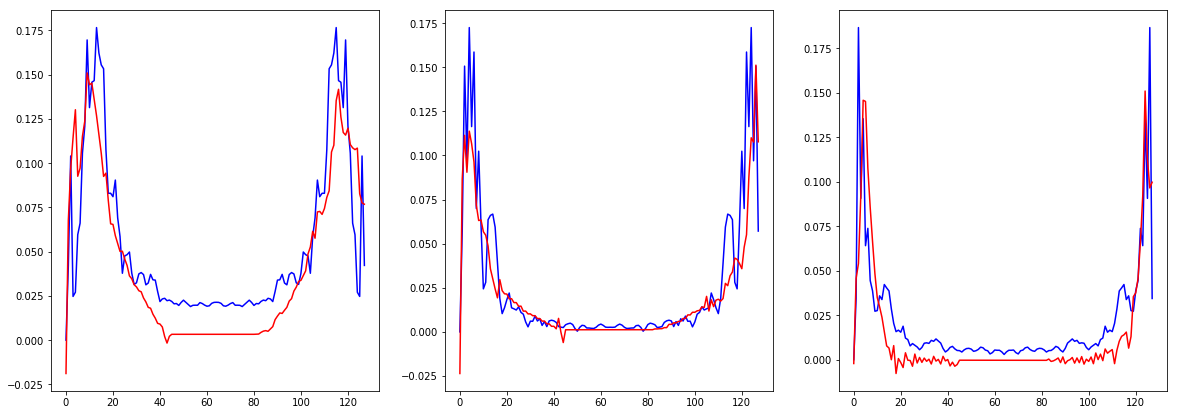

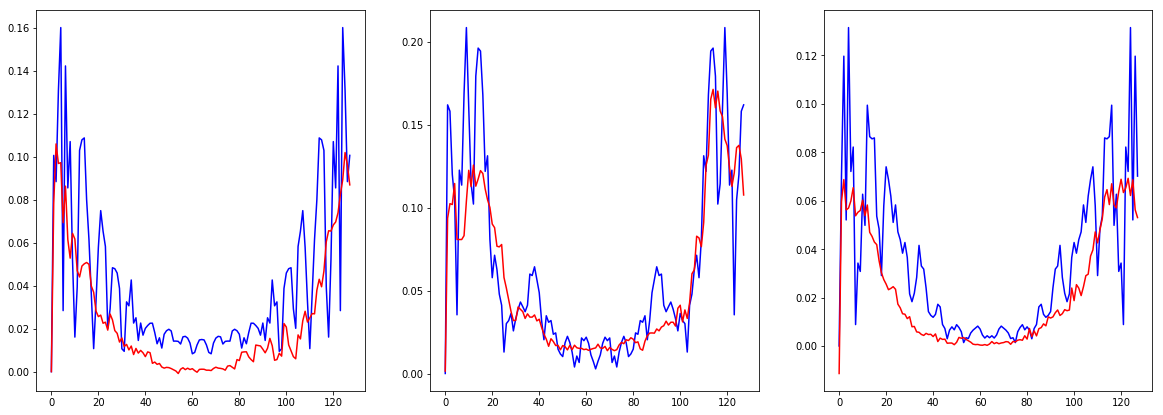

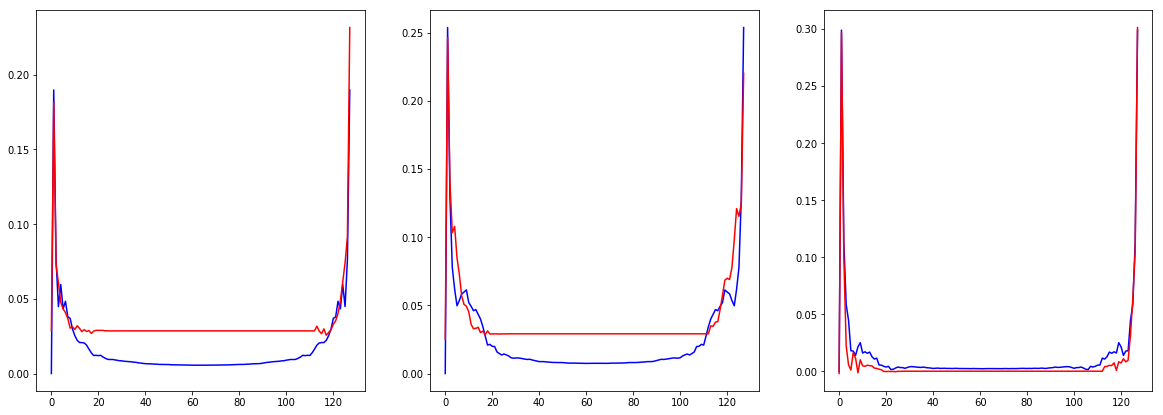

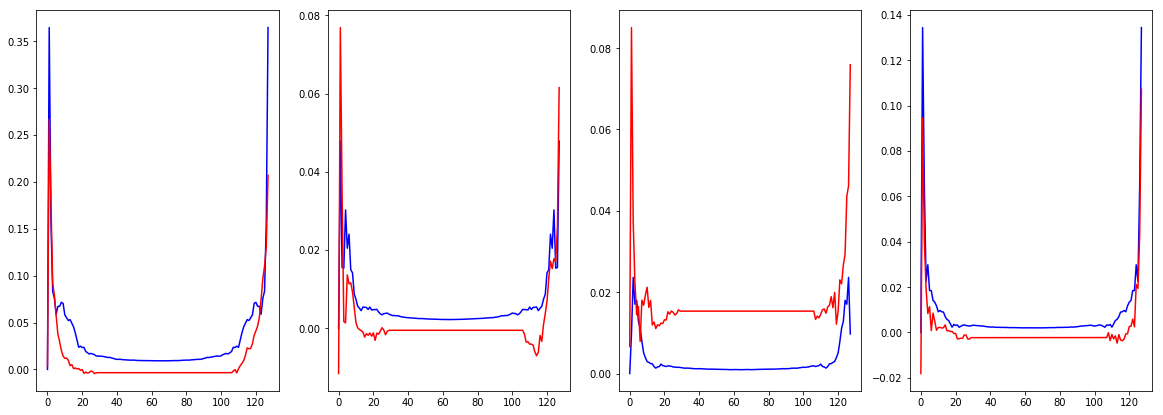

In [37]:
sample = 32
gyroy = gyroModel.predict(gyro_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gyro_train[sample,:,channel],'b')
    plot(gyroy[0,:,channel],'r')
linearAccy = linearAccModel.predict(linearAcc_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(linearAcc_train[sample,:,channel],'b')
    plot(linearAccy[0,:,channel],'r')
gravityy = gravityModel.predict(gravity_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gravity_train[sample,:,channel],'b')
    plot(gravityy[0,:,channel],'r')
gameVecy = gameVecModel.predict(gameVec_train[sample].reshape(1,128,4))
fig=plt.figure(figsize=(20,7))
for channel in range(4):
    plt.subplot(1,4,channel+1)
    plot(gameVec_train[sample,:,channel],'b')
    plot(gameVecy[0,:,channel],'r')